In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# Define base path to the root dataset folder
base_path = "/kaggle/input/dataset-mlsd"

# Define paths to each dataset's innermost folder
pneumonia_path = os.path.join(base_path, "Split_Pneumonia", "Split_Pneumonia")
covid19_path = os.path.join(base_path, "Split_COVID19", "Split_COVID19")
tuberculosis_path = os.path.join(base_path, "Split_Tuberculosis", "Split_Tuberculosis")

print("Pneumonia path:", pneumonia_path)
print("COVID-19 path:", covid19_path)
print("Tuberculosis path:", tuberculosis_path)

Pneumonia path: /kaggle/input/dataset-mlsd/Split_Pneumonia/Split_Pneumonia
COVID-19 path: /kaggle/input/dataset-mlsd/Split_COVID19/Split_COVID19
Tuberculosis path: /kaggle/input/dataset-mlsd/Split_Tuberculosis/Split_Tuberculosis


Define Data Generators with Augmentation

In [3]:
# Define data generators
def get_data_generators(dataset_path, batch_size=32, target_size=(224, 224)):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    train_gen = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'val'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen, test_gen

Build the DenseNet121 Model

In [4]:
def build_densenet121_model(num_classes):
    # Replace the weights URL with the local path
    weights_path = "/kaggle/input/densenet121h5/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    base_model = DenseNet121(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Regularization
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers initially
    return model

Define Training Function

In [5]:
def train_model(dataset_name, dataset_path, epochs=10, batch_size=32):
    print(f"\nTraining on {dataset_name} dataset...\n")
    
    # Get data generators
    train_gen, val_gen, test_gen = get_data_generators(dataset_path, batch_size=batch_size)
    num_classes = len(train_gen.class_indices)
    
    # Build the model
    model = build_densenet121_model(num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Define callbacks
    checkpoint = ModelCheckpoint(f"{dataset_name}_DenseNet121.keras", 
                                  save_best_only=True, 
                                  monitor='val_accuracy', 
                                  mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    
    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, early_stop]
    )
    
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nTest Accuracy for {dataset_name}: {test_acc * 100:.2f}%")
    
    return history, model, test_gen

Train the Model on All Datasets

In [6]:
# Train on Pneumonia dataset
history_pneumonia, model_pneumonia, test_gen_pneumonia = train_model("Pneumonia", pneumonia_path)

# Train on COVID-19 dataset
history_covid19, model_covid19, test_gen_covid19 = train_model("COVID-19", covid19_path)

# Train on Tuberculosis dataset
history_tuberculosis, model_tuberculosis, test_gen_tuberculosis = train_model("Tuberculosis", tuberculosis_path)


Training on Pneumonia dataset...

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 151s 835ms/step - accuracy: 0.7574 - loss: 0.5688 - val_accuracy: 0.9060 - val_loss: 0.2558
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 86s 556ms/step - accuracy: 0.8641 - loss: 0.3146 - val_accuracy: 0.9197 - val_loss: 0.2325
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 549ms/step - accuracy: 0.8804 - loss: 0.2814 - val_accuracy: 0.9009 - val_loss: 0.2527
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 555ms/step - accuracy: 0.8923 - loss: 0.2723 - val_accuracy: 0.9248 - val_loss: 0.2097
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 546ms/step - accuracy: 0.8935 - loss: 0.2483 - val_accuracy: 0.9111 - val_loss: 0.2393
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 548ms/step - accuracy: 0.9003 - loss: 0.2437 - val_accuracy: 0.9248 - val_loss: 0.2040
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 549ms/step - accuracy: 0.8898 - loss: 0.2618 - val_accuracy: 0.9316 - val_loss: 0.2004
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - accuracy: 0.9010 - loss: 0.2502 - va

Analyze Results

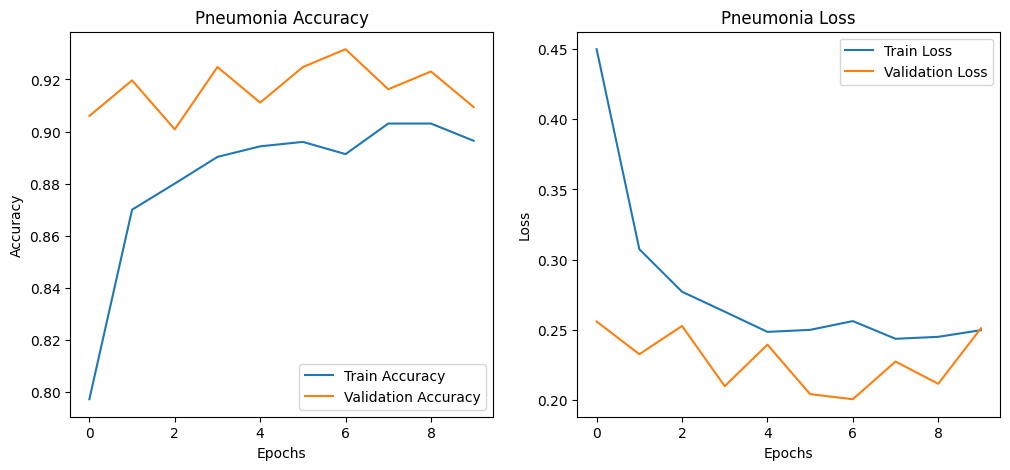

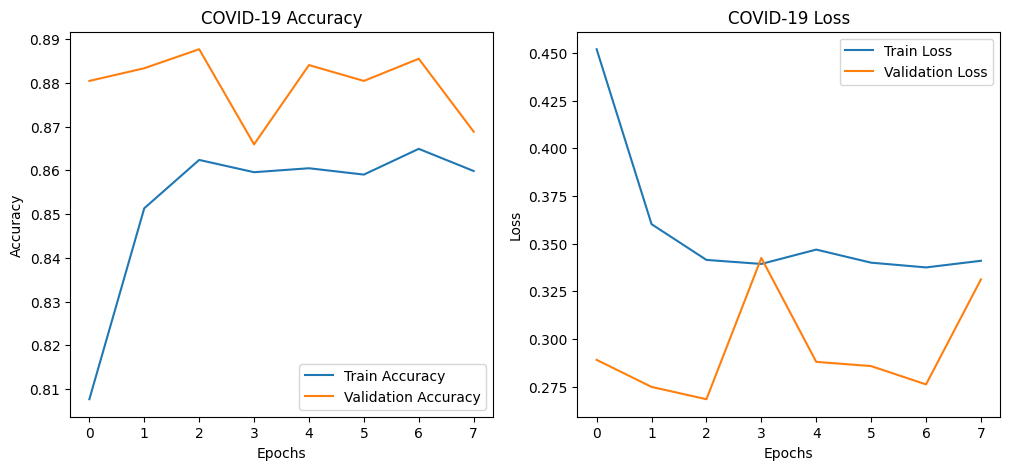

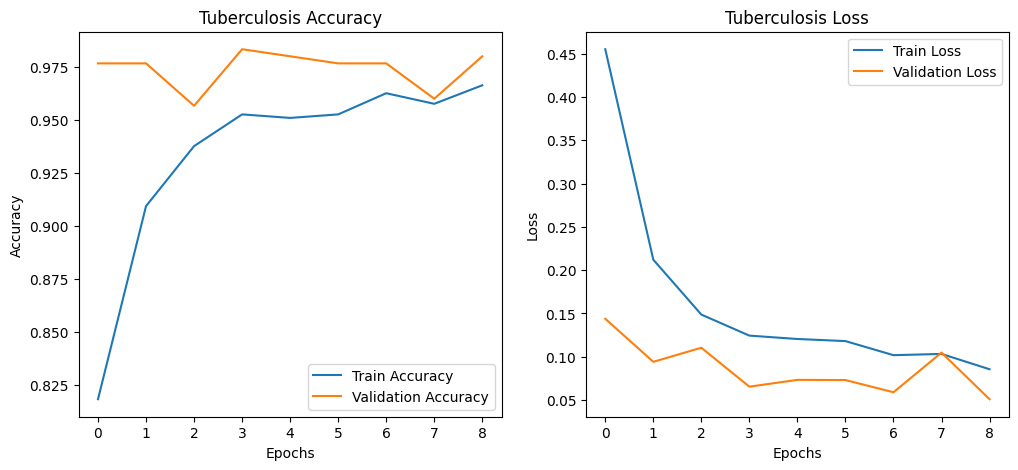

In [9]:
# Plot accuracy and loss
def plot_history(history, dataset_name):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{dataset_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Call the plot function for each dataset
plot_history(history_pneumonia, "Pneumonia")
plot_history(history_covid19, "COVID-19")
plot_history(history_tuberculosis, "Tuberculosis")

Classification Reports and Confusion Matrices

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step
Classification Report for Pneumonia:

                              precision    recall  f1-score   support

   normal x-ray chest images       0.92      0.84      0.88       159
pneumonia x-ray chest images       0.94      0.97      0.96       428

                    accuracy                           0.94       587
                   macro avg       0.93      0.91      0.92       587
                weighted avg       0.94      0.94      0.94       587



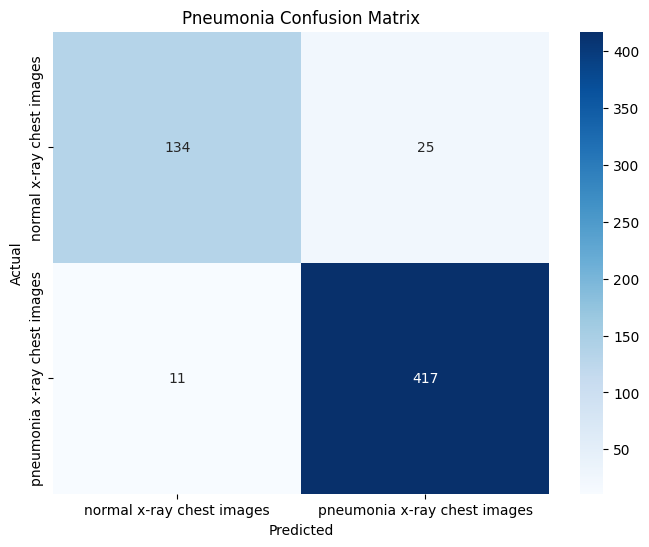

44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step
Classification Report for COVID-19:

                            precision    recall  f1-score   support

      covid19 x-ray images       0.93      0.60      0.73       363
normal chest  x-ray images       0.87      0.98      0.92      1020

                  accuracy                           0.88      1383
                 macro avg       0.90      0.79      0.83      1383
              weighted avg       0.89      0.88      0.87      1383



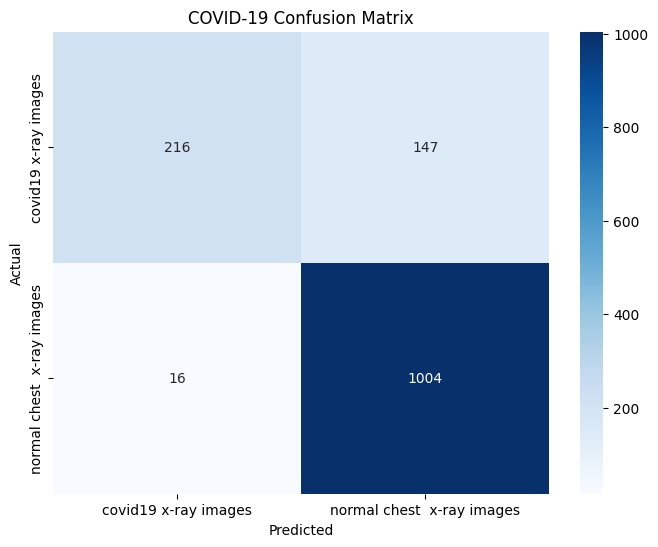

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 918ms/step
Classification Report for Tuberculosis:

                                 precision    recall  f1-score   support

      normal x-ray chest images       0.98      0.88      0.93        52
tuberculosis x-ray chest images       0.98      1.00      0.99       250

                       accuracy                           0.98       302
                      macro avg       0.98      0.94      0.96       302
                   weighted avg       0.98      0.98      0.98       302



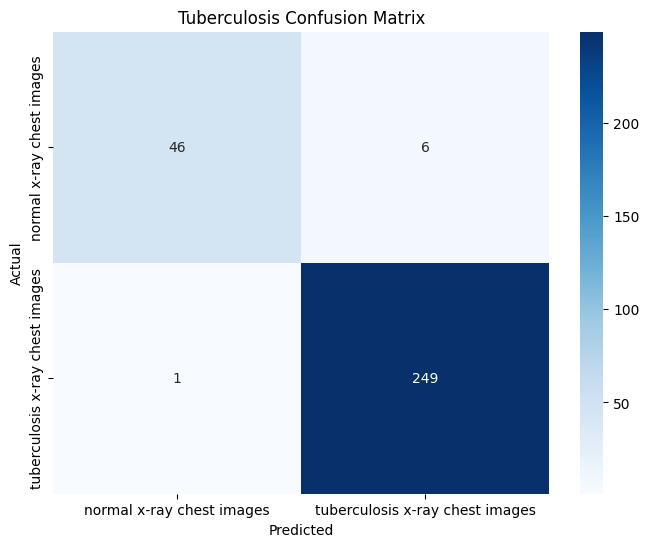

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(test_gen, model, dataset_name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    class_labels = list(test_gen.class_indices.keys())
    
    # Classification Report
    print(f"Classification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate each model
evaluate_model(test_gen_pneumonia, model_pneumonia, "Pneumonia")
evaluate_model(test_gen_covid19, model_covid19, "COVID-19")
evaluate_model(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

Generate and Analyze Precision-Recall and ROC Curves

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step

Precision-Recall Curve for Pneumonia:


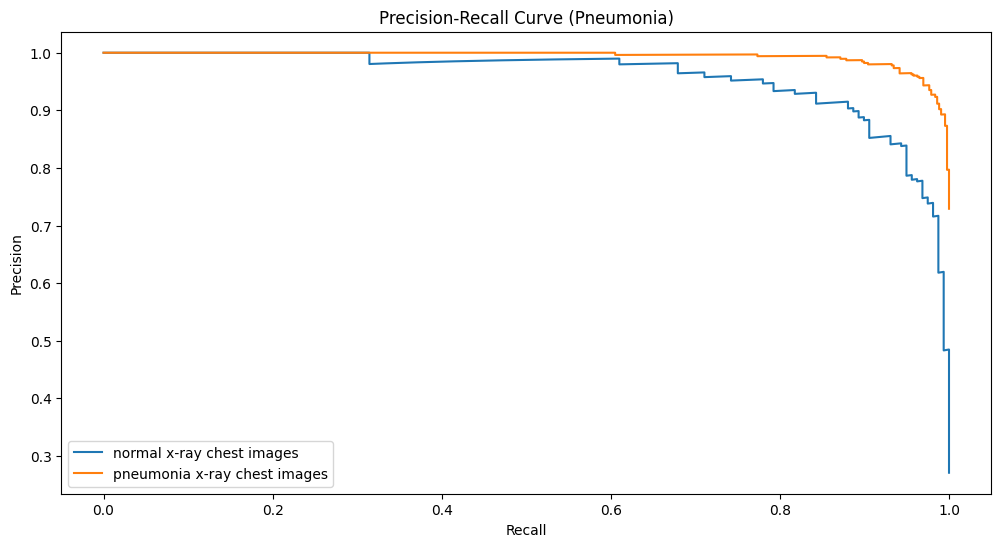


ROC Curve for Pneumonia:


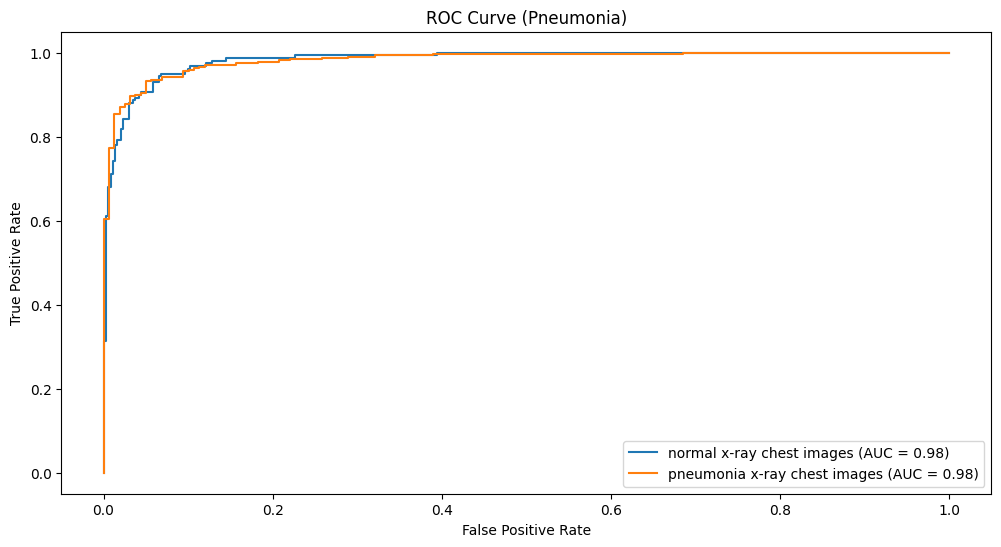

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

Precision-Recall Curve for COVID-19:


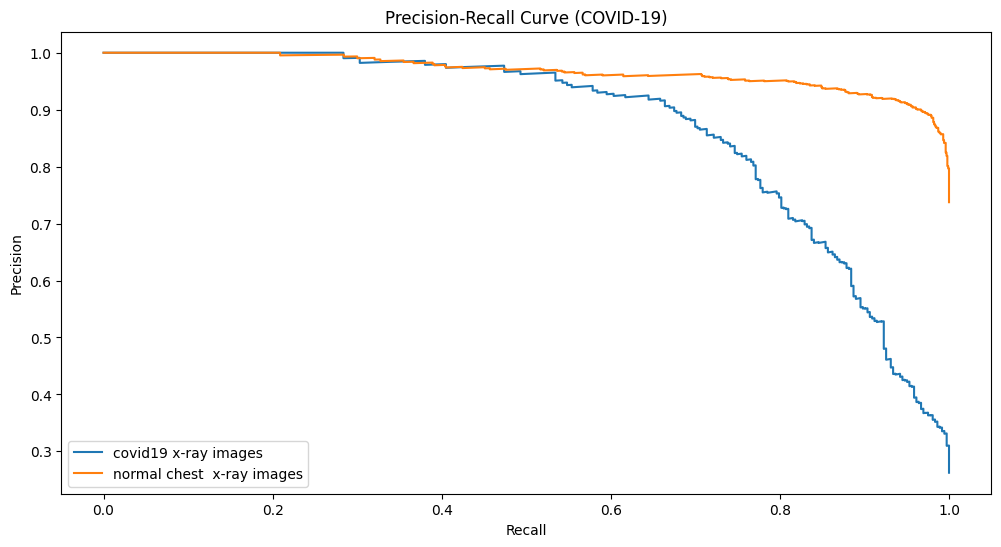


ROC Curve for COVID-19:


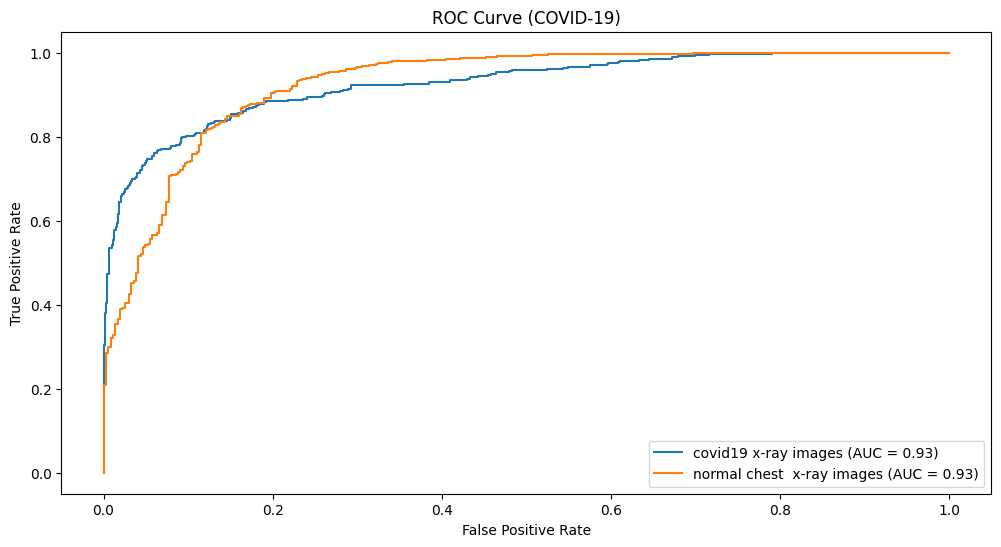

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Precision-Recall Curve for Tuberculosis:


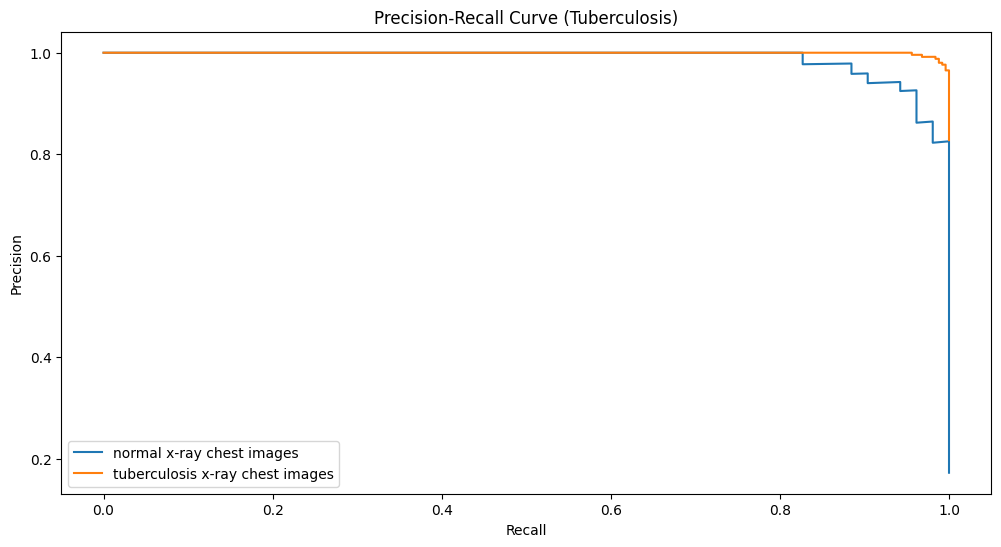


ROC Curve for Tuberculosis:


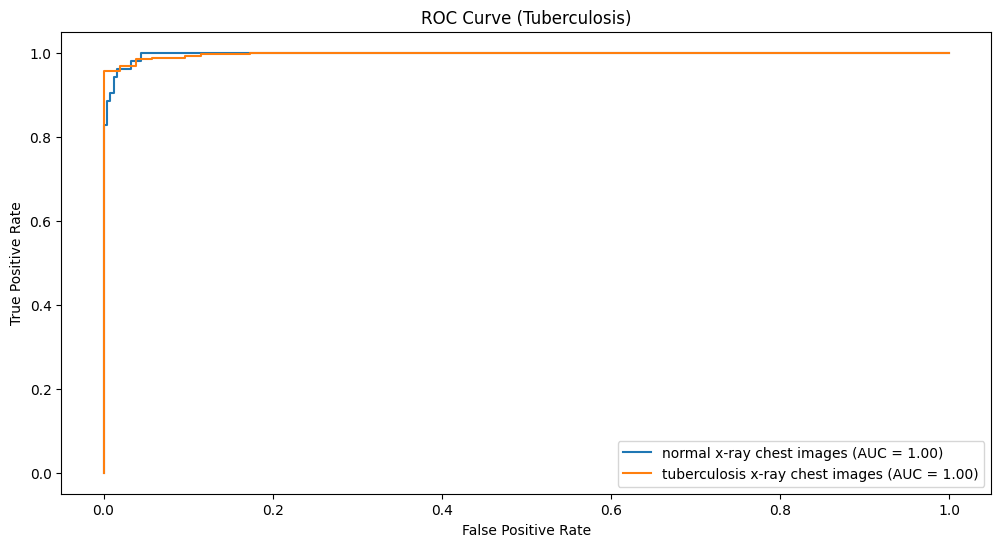

In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
def plot_precision_recall_and_roc(test_gen, model, dataset_name):
    # Get true labels and predicted probabilities
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    
    # Precision-Recall Curve for each class
    print(f"\nPrecision-Recall Curve for {dataset_name}:")
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(test_gen.class_indices.keys()):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_name}')
    plt.title(f'Precision-Recall Curve ({dataset_name})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    # ROC Curve for each class
    print(f"\nROC Curve for {dataset_name}:")
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(test_gen.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.title(f'ROC Curve ({dataset_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
# Generate Precision-Recall and ROC Curves for Pneumonia
plot_precision_recall_and_roc(test_gen_pneumonia, model_pneumonia, "Pneumonia")

# Generate Precision-Recall and ROC Curves for COVID-19
plot_precision_recall_and_roc(test_gen_covid19, model_covid19, "COVID-19")

# Generate Precision-Recall and ROC Curves for Tuberculosis
plot_precision_recall_and_roc(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

CALIBRATION CURVE

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


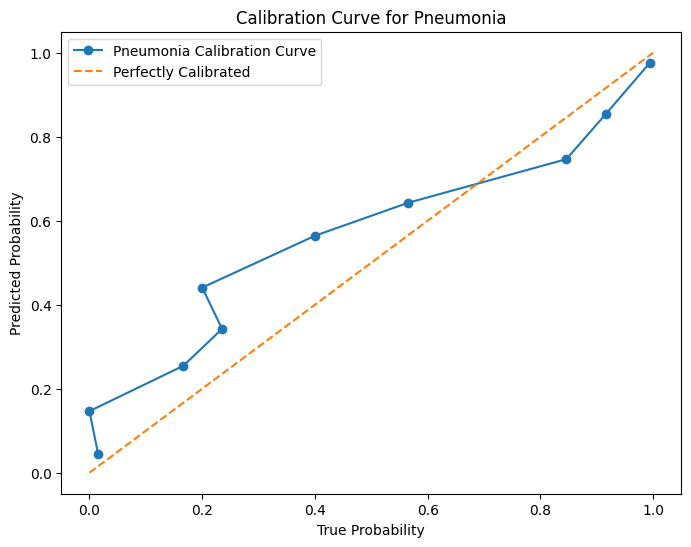

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step


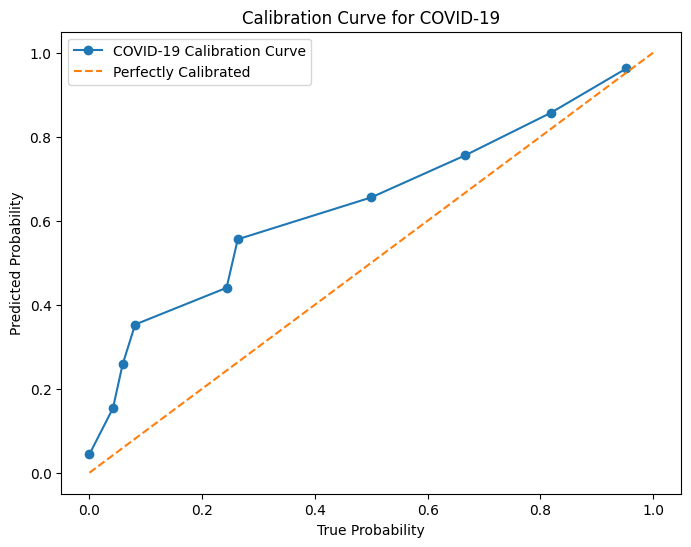

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


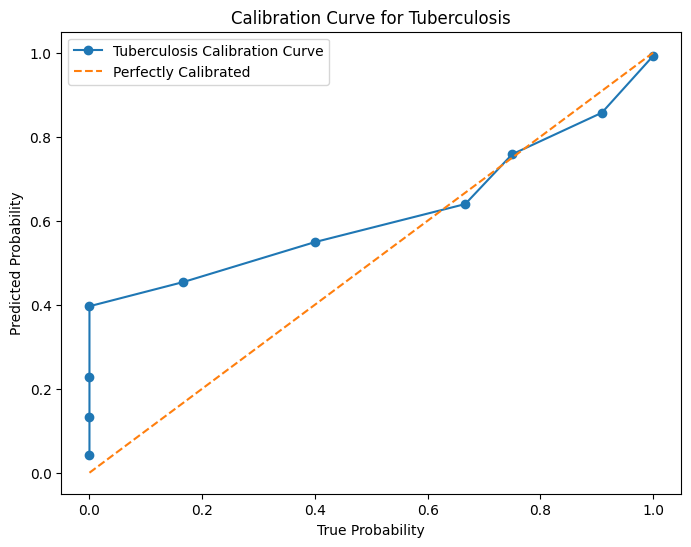

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(test_gen, model, dataset_name):
    # Get true labels and predicted probabilities
    y_true = test_gen.classes
    y_pred = model.predict(test_gen)  # Use predict to get probabilities

    # For multi-class classification, extract probabilities for each class
    # If it's binary classification, y_pred[:, 1] will give you the probability of the positive class
    if y_pred.shape[1] > 2:  # Multi-class classification
        y_pred = y_pred[:, 1]  # Modify this line for specific classes if needed
    else:
        y_pred = y_pred[:, 1]  # For binary, take the second column for the positive class
    
    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    
    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_true, prob_pred, marker='o', label=f'{dataset_name} Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('True Probability')
    plt.ylabel('Predicted Probability')
    plt.title(f'Calibration Curve for {dataset_name}')
    plt.legend()
    plt.show()

# Calibration Curve for each dataset
plot_calibration_curve(test_gen_pneumonia, model_pneumonia, "Pneumonia")
plot_calibration_curve(test_gen_covid19, model_covid19, "COVID-19")
plot_calibration_curve(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

ACCURACY PER CLASS

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

def accuracy_per_class(test_gen, model, dataset_name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy per class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print(f"Accuracy per Class for {dataset_name}:")
    for i, label in enumerate(test_gen.class_indices.keys()):
        print(f"Accuracy for {label}: {class_accuracy[i]:.2f}")

# Accuracy per class for each dataset
accuracy_per_class(test_gen_pneumonia, model_pneumonia, "Pneumonia")
accuracy_per_class(test_gen_covid19, model_covid19, "COVID-19")
accuracy_per_class(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step
Accuracy per Class for Pneumonia:
Accuracy for normal x-ray chest images: 0.84
Accuracy for pneumonia x-ray chest images: 0.97
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
Accuracy per Class for COVID-19:
Accuracy for covid19 x-ray images: 0.60
Accuracy for normal chest  x-ray images: 0.98
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Accuracy per Class for Tuberculosis:
Accuracy for normal x-ray chest images: 0.88
Accuracy for tuberculosis x-ray chest images: 1.00
